In [68]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
from astroML.time_series import \
    lomb_scargle, lomb_scargle_bootstrap

from ztf_summerschool import source_lightcurve, barycenter_times
%matplotlib inline

#Hands-On Exercise 3:
Period Finding
========
One of the fundamental tasks of time-domain astronomy is determining if a source is periodic, and if so, measuring the period.  Period measurements are a vital first step for more detailed scientific study, which may include source classification (e.g., RR Lyrae, W Uma), lightcurve modeling (binaries), or luminosity estimation (Cepheids).

Binary stars in particular have lightcurves which may show a wide variety of shapes, depending on the nature of the stars and the system geometry.

In this workbook we will develop a basic toolset for the generic problem of finding periodic sources.

***
by Eric Bellm (2014-2015)

Let's use the relative-photometry corrected light curves we built in Exercise 2. We'll use the utility function `source_lightcurve` to load the columns MJD, magnitude, and magnitude error.  Note that we will use days as our time coordinate throughout the homework.

In [69]:
# point to our previously-saved data
reference_catalog = '../data/PTF_Refims_Files/PTF_d022683_f02_c06_u000114210_p12_sexcat.ctlg'
outfile = reference_catalog.split('/')[-1].replace('ctlg','shlv')

We'll start by loading the data from our favorite star, which has coordinates $\alpha_\mathrm{J2000}, \delta_\mathrm{J2000} = (312.503802, -0.706603)$.

In [70]:
ra_fav, dec_fav = (312.503802, -0.706603)
mjds, mags, magerrs = source_lightcurve('../data/'+outfile, ra_fav, dec_fav)

## Exercise 0:  Barycentering

Our times are Modified Julian Date *on earth*.  We need to correct them for Earth's motion around the sun (this is called heliocentering or barycentering).  How big is the error if we do not make this correction?


In [4]:
# CALCULATE AN ANSWER HERE
import astropy.constants as const
(const.au/const.c).to(u.min)

<Quantity 8.316746397269274 min>

We have provided a script to barycenter the data--note that it assumes that the data come from the P48.  Use the `bjds` (barycentered modified julian date) variable through the remainder of this notebook.

In [72]:
bjds = barycenter_times(mjds,ra_fav,dec_fav)

*Optional exercise: plot a histogram of the time differences between the barycentered and non-barycentered data.*

## Exercise 1: Getting started plotting

Complete this function for plotting the lightcurve:


In [7]:
# define plot function
def plot_data(mjd, mag, magerr): # COMPLETE THIS LINE
    plt.errorbar(mjd, mag, yerr=magerr, # COMPLETE THIS LINE
        fmt = '_', capsize=0)
    plt.xlabel('Date (MJD)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


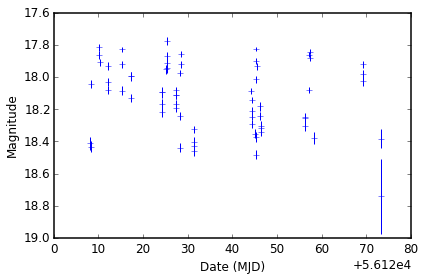

In [8]:
# run plot function
plot_data(bjds, mags, magerrs)

In [8]:
# documentation for the lomb_scargle function
help(lomb_scargle)

Help on built-in function lomb_scargle in module astroML_addons.periodogram:

lomb_scargle(...)
    (Generalized) Lomb-Scargle Periodogram with Floating Mean
    
    Parameters
    ----------
    t : array_like
        sequence of times
    y : array_like
        sequence of observations
    dy : array_like
        sequence of observational errors
    omega : array_like
        frequencies at which to evaluate p(omega)
    generalized : bool
        if True (default) use generalized lomb-scargle method
        otherwise, use classic lomb-scargle.
    subtract_mean : bool
        if True (default) subtract the sample mean from the data before
        computing the periodogram.  Only referenced if generalized is False.
    significance : None or float or ndarray
        if specified, then this is a list of significances to compute
        for the results.
    
    Returns
    -------
    p : array_like
        Lomb-Scargle power associated with each frequency omega
    z : array_like
  

## Exercise 2: Determining the frequency grid

One of the challenges of using the LS periodogram is determining the appropriate frequency grid to search.  We have to select the minimum and maximum frequencies as well as the bin size.

If we don't include the true frequency in our search range, we can't find the period!

If the bins are too coarse, true peaks may be lost.  If the bins are too fine, the periodogram becomes very slow to compute.

The first question to ask is what range of frequencies our data is sensitive to.

### Exercise 2.1

What is the smallest angular frequency $\omega_{\rm min}$ our data is sensitive to?  (Hint: smallest frequency => largest time)

In [9]:
freq_min =  2*np.pi / (bjds[-1]-bjds[0]) # COMPLETE
print 'The minimum frequency our data is sensitive to is {:.3f} radian/days, corresponding to a period of {:.3f} days'.format(freq_min, 2*np.pi/freq_min)

The minimum frequency our data is sensitive to is 0.096 radian/days, corresponding to a period of 65.125 days


### Exercise 2.2

Determining the highest frequency we are sensitive to turns out to be complicated.  

if $\Delta t$ is the difference between consecutive observations,
$\pi$/median($\Delta t$) is a good starting point, although in practice we may be sensitive to frequencies even higher than $2 \pi$/min($\Delta t$) depending on the details of the sampling.

What is the largest angular frequency $\omega_{\rm max}$ our data is sensitive to?  

In [10]:
freq_max = np.pi / np.median(bjds[1:]-bjds[:-1]) # COMPLETE
print 'The maximum frequency our data is sensitive to is APPROXIMATELY {:.3f} radian/days, corresponding to a period of {:.3f} days'.format(freq_max, 2*np.pi/freq_max)

The maximum frequency our data is sensitive to is APPROXIMATELY 81.179 radian/days, corresponding to a period of 0.077 days


### Exercise 2.3

We need enough bins to resolve the periodogram peaks, which [have](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) frequency width $\Delta f \sim 2\pi/ (t_{\rm max} - t_{\rm min}) = \omega_{\rm min}$.
If we want to have 5 samples of $\Delta f$, how many bins will be in our periodogram?  Is this computationally feasible?

In [11]:
n_bins =  np.round(5 * (freq_max-freq_min)/freq_min) # COMPLETE
print n_bins

4202.0


### Exercise 2.4

Let's wrap this work up in a convenience function that takes as input a list of observation times and returns a frequency grid with decent defaults.

In [12]:
# define frequency function
def frequency_grid(times):
    freq_min = 2*np.pi / (times[-1]-times[0]) # COMPLETE
    freq_max = np.pi / np.median(times[1:]-times[:-1]) # COMPLETE
    n_bins =  np.floor((freq_max-freq_min)/freq_min * 5.) # COMPLETE
    print 'Using {} bins'.format(n_bins)
    return np.linspace(freq_min, freq_max, n_bins)

In [13]:
# run frequency function
omegas = frequency_grid(bjds)

Using 4202.0 bins


In some cases you'll want to generate the frequency grid by hand, either to extend to higher frequencies (shorter periods) than found by default, to avoid generating too many bins, or to get a more precise estimate of the period.  In that case use the following code.  We'll use a large fixed number of bins to smoothly sample the periodogram as we zoom in.

In [14]:
# provided alternate frequency function
def alt_frequency_grid(Pmin, Pmax, n_bins = 5000):
    """Generate an angular frequency grid between Pmin and Pmax (assumed to be in days)"""
    freq_max = 2*np.pi / Pmin
    freq_min = 2*np.pi / Pmax
    return np.linspace(freq_min, freq_max, n_bins)

## Exercise 3: Computing the Periodogram

Calculate the LS periodiogram and plot the power.

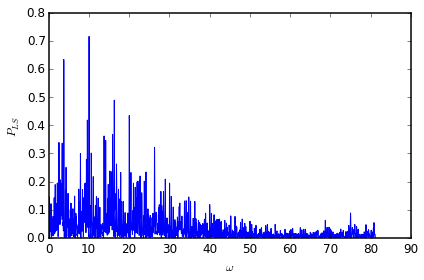

In [15]:
# calculate and plot LS periodogram
P_LS = lomb_scargle(bjds, mags, magerrs, omegas) # COMPLETE
plt.plot(omegas, P_LS)
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

In [16]:
# provided: define function to find best period
def LS_peak_to_period(omegas, P_LS):
    """find the highest peak in the LS periodogram and return the corresponding period."""
    max_freq = omegas[np.argmax(P_LS)]
    return 2*np.pi/max_freq

In [17]:
# run function to find best period
best_period = LS_peak_to_period(omegas, P_LS)
print "Best period: {} days".format(best_period)

Best period: 0.627251245434 days


## Exercise 4: Phase Calculation
Complete this function that returns the phase of an observation (in the range 0-1) given its period.  For simplicity set the zero of the phase to be the time of the initial observation.

Hint: Consider the python modulus operator, `%`.

Add a keyword that allows your function to have an optional user-settable time of zero phase.

In [18]:
# define function to phase lightcurves
def phase(time, period, t0 = None):
    """ Given an input array of times and a period, return the corresponding phase."""
    if t0 is None:
        t0 = time[0]
    return ((time - t0)/period) % 1 # COMPLETE

## Exercise 5: Phase Plotting

Plot the phased lightcurve at the best-fit period.

In [19]:
# define function to plot phased lc
def plot_phased_lc(mjds, mags, magerrs, period, t0=None):
    phases = phase(mjds, period, t0=t0) # COMPLETE
    plt.errorbar(phases,mags,yerr=magerrs, #COMPLETE
        fmt = '_', capsize=0)
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()

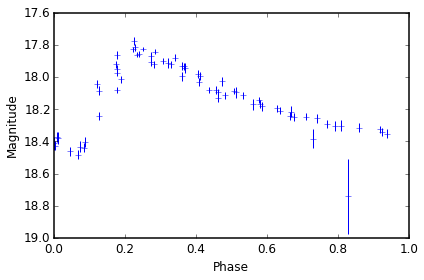

In [20]:
# run function to plot phased lc
plot_phased_lc(bjds, mags, magerrs, best_period)

How does that look?  Do you think you are close to the right period?

Try re-running your analysis using the `alt_frequency_grid` command, searching a narrower period range around the best-fit period.

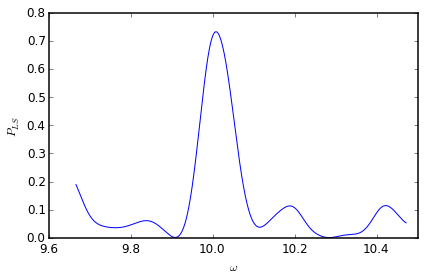

In [23]:
# COMPLETE
omegas = alt_frequency_grid(.6,.65)
P_LS = lomb_scargle(bjds, mags, magerrs, omegas)
plt.plot(omegas, P_LS)
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

Best period: 0.627812842146 days


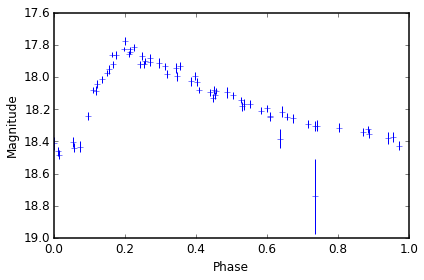

In [24]:
# COMPLETE
best_period = LS_peak_to_period(omegas, P_LS)
print "Best period: {} days".format(best_period)
plot_phased_lc(bjds, mags, magerrs, best_period)

## [Challenge] Exercise 6: Calculating significance of the period detection

Real data may have *aliases*--frequency components that appear because of the sampling of the data, such as once per night.  Bootstrap significance tests, which shuffle the data values around but keep the times the same, can help rule these out.

Calculate the chance probability of finding a LS peak higher than the observed value in random data observed at the specified intervals: use `lomb_scargle_bootstrap` and `np.percentile` to find the 95 and 99 percent significance levels and plot them over the LS power.



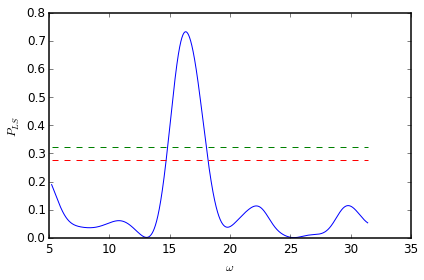

In [78]:
D = lomb_scargle_bootstrap(mjds, mags, magerrs, omegas,
   generalized=True, N_bootstraps=1000) # COMPLETE
sig99, sig95 = np.percentile(D, [99, 95]) # COMPLETE
plt.plot(omegas, P_LS)
plt.plot([omegas[0],omegas[-1]], sig99*np.ones(2),'--')
plt.plot([omegas[0],omegas[-1]], sig95*np.ones(2),'--')
plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

## [Challenge] Exercise 7: Find periods of other sources

Now try finding the periods of these sources:

* 312.066287628, -0.983790357518 
* 311.967177518 -0.886275170839
* 312.263445107 -0.342008023626
* 312.050877142 -1.0632849268
* 312.293550866 -0.783896411315

## [Challenge] Exercise 9: gatspy

Try using the [`gatspy`](http://www.astroml.org/gatspy/) package to search for periods.  It uses a slightly different interface but has several nice features, such as automatic zooming on candidate frequency peaks.

Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1358 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.627779598284


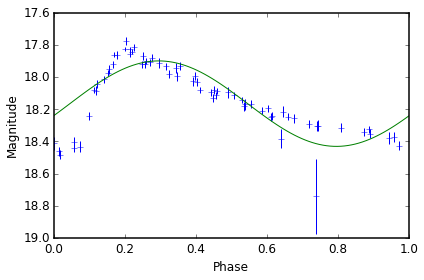

In [49]:
import gatspy
ls = gatspy.periodic.LombScargleFast()
ls.optimizer.period_range = (0.2,1.2)
# we have to subtract the t0 time so the model plotting has the correct phase origin
ls.fit(bjds-bjds[0],mags,magerrs)
gatspy_period = ls.best_period
print gatspy_period
plot_phased_lc(bjds, mags, magerrs, gatspy_period)
p = np.linspace(0,gatspy_period,100)
plt.plot(p/gatspy_period,ls.predict(p,period=gatspy_period))


## [Challenge] Exercise 10: Alternate Algorithms 

Lomb-Scargle is equivalent to fitting a sinusoid to the phased data, but many kinds of variable stars do not have phased lightcurves that are well-represented by a sinusoid.  Other algorithms, such as those that attempt to minimize the dispersion within phase bins over a grid of trial phases, may be more successful in such cases.  See [Graham et al (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) for a review.  




Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1358 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.627706988366


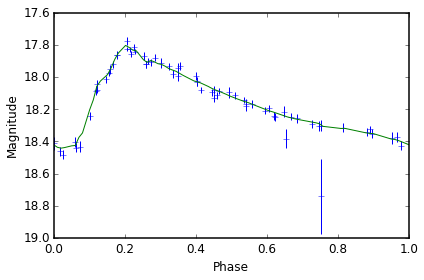

In [50]:
ss = gatspy.periodic.SuperSmoother(fit_period=True)
ss.optimizer.period_range = (0.2, 1.2)
ss.fit(bjds-bjds[0],mags,magerrs)
gatspy_period = ss.best_period
print gatspy_period
plot_phased_lc(bjds, mags, magerrs, gatspy_period)
p = np.linspace(0,gatspy_period,100)
plt.plot(p/gatspy_period,ss.predict(p,period=gatspy_period))

## [Challenge] Exercise 10: Multi-harmonic fitting 

Both AstroML and gatspy include code for including multiple Fourier components in the fit, which can better fit lightcurves that don't have a simple sinusoidal shape (like RR Lyrae).

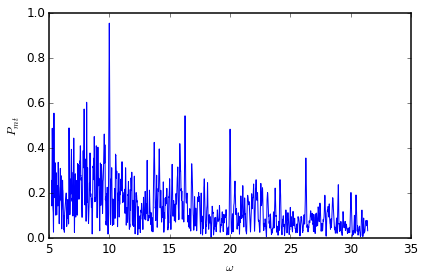

In [76]:
from astroML.time_series import multiterm_periodogram
omegas = alt_frequency_grid(.2,1.2)
P_mt = multiterm_periodogram(bjds, mags, magerrs, omegas) #COMPLETE
plt.plot(omegas, P_mt)
plt.xlabel('$\omega$')
plt.ylabel('$P_{mt}$')

Best period: 0.627555183597 days


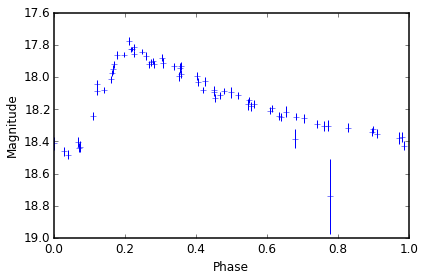

In [77]:
best_period = LS_peak_to_period(omegas, P_mt) # COMPLETE
print "Best period: {} days".format(best_period)
plot_phased_lc(bjds, mags, magerrs, best_period)

Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1358 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.627695024836


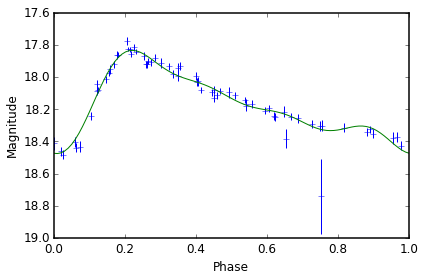

In [75]:
ls = gatspy.periodic.LombScargle(Nterms=4)
ls.optimizer.period_range = (0.2,1.2)
ls.fit(bjds-bjds[0],mags,magerrs)
gatspy_period = ls.best_period
print gatspy_period
plot_phased_lc(bjds, mags, magerrs, gatspy_period)
p = np.linspace(0,gatspy_period,100)
plt.plot(p/gatspy_period,ls.predict(p,period=gatspy_period))

## [Challenge] Exercise 8: Compute all periods

This is a big one: can you compute periods for *all* of the sources in our database with showing evidence of variability?  How will you compute variablity?  How can you tell which sources are likely to have good periods?


In [43]:
# open the stored data
import shelve
import astropy
shelf = shelve.open('../data/'+outfile)
all_mags = shelf['mags']
all_mjds = shelf['mjds']
all_errs = shelf['magerrs']
all_coords = shelf['ref_coords']
shelf.close()

In [64]:
# loop over stars
variable_inds = []
best_periods = []
best_power = []
chisq_min = 5

with astropy.utils.console.ProgressBar(all_mags.shape[0],ipython_widget=True) as bar:
    for i in range(all_mags.shape[0]):
        # make sure there's real data
        wgood = (all_mags[i,:].mask == False)
        n_obs = np.sum(wgood)
        if n_obs < 40:
            continue
        # find variable stars using chi-squared.  If the data points are consistent with a line, reduced chisq ~ 1
        chisq = np.sum((all_mags[i,:]-np.mean(all_mags[i,:]))**2./all_errs[i,:]**2./(n_obs - 1.))
        if chisq < chisq_min:
            continue
        variable_inds.append(i)
        bjds = barycenter_times(all_mjds[wgood],all_coords[i].ra.degree,all_coords[i].dec.degree)
        ls = gatspy.periodic.LombScargleFast()
        ls.optimizer.period_range = (0.2,1.2)
        ls.fit(bjds-bjds[0],all_mags[i,:][wgood],all_errs[i,:][wgood])
        best_periods.append(ls.best_period)
        best_power.append(float(ls.periodogram(ls.best_period)))
        bar.update()

Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1357 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0966
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1357 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1358 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0965
 - Using 5 steps per peak; omega_step = 0.0193
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 1358 steps
Zooming-in on 5 candidate peaks:
 - Computing period

In [65]:
# cut out the NaNs:
w = np.isfinite(np.array(best_power))
best_power = np.array(best_power)[w]
best_periods = np.array(best_periods)[w]
variable_inds = np.array(variable_inds)[w]

# sort by most power in the LS peak
s = np.argsort(best_power)
# reverse
s = s[::-1]

312.066287628 -0.983790357518
312.333717298 -1.07863418247
311.967177518 -0.886275170839
312.128564619 -0.565452492487
312.503953716 -0.706546810615
312.13913564 -1.08870291745
312.050877142 -1.0632849268
312.318837893 -0.966725115777
312.238549884 -0.896705530201
312.446789665 -0.0690508543551


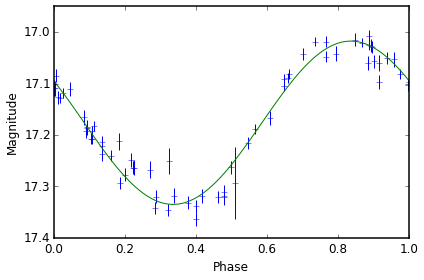

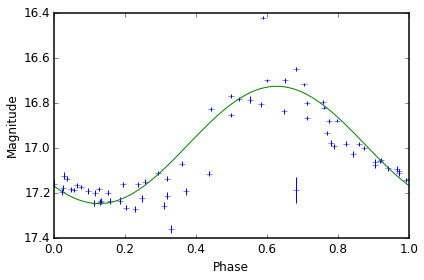

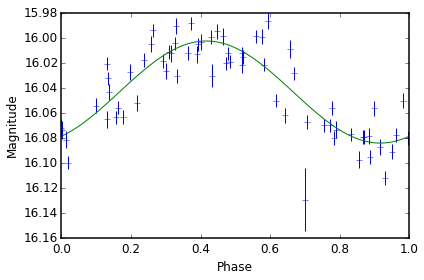

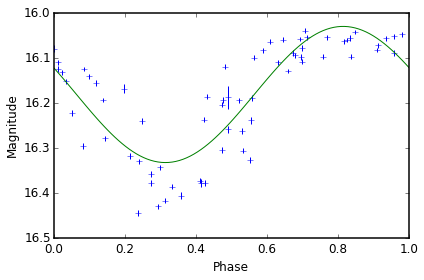

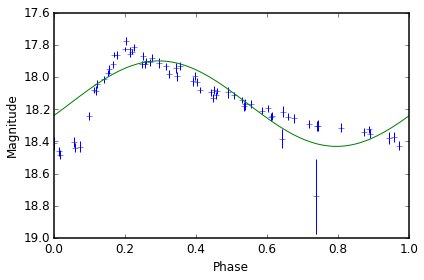

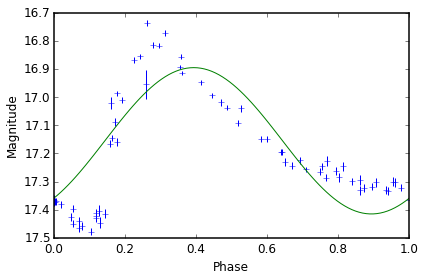

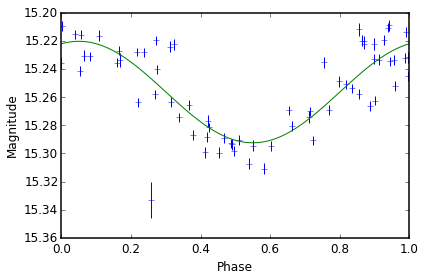

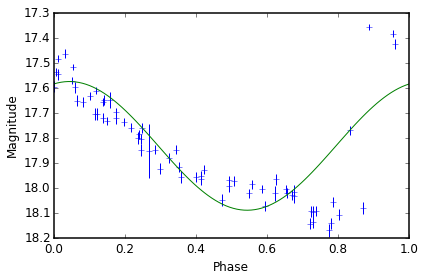

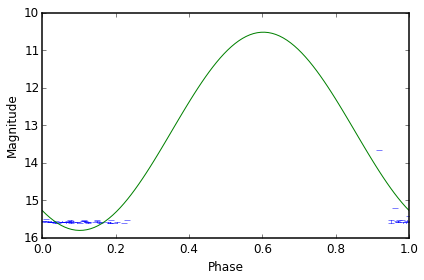

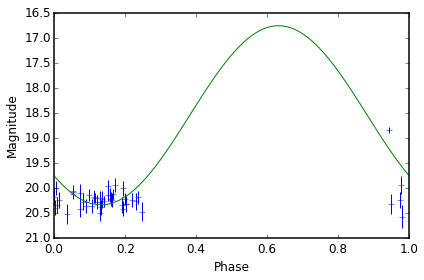

In [66]:
iis = variable_inds[s][:10]
periods = best_periods[s][:10]
for i,period in zip(iis,periods):
    # make sure there's real data
    wgood = (all_mags[i,:].mask == False)
    print all_coords[i].ra.degree,all_coords[i].dec.degree
    bjds = barycenter_times(all_mjds[wgood],all_coords[i].ra.degree,all_coords[i].dec.degree)
    
    ls = gatspy.periodic.LombScargleFast()
    ls.optimizer.period_range = (0.2,2)
    ls.fit(bjds-bjds[0],all_mags[i,:][wgood],all_errs[i,:][wgood])

    plt.figure()
    plot_phased_lc(bjds, all_mags[i,:][wgood], all_errs[i,:][wgood], period)
    p = np.linspace(0,period,100)
    plt.plot(p/period,ls.predict(p,period=period))

*Other effects to consider*



Many eclipsing binaries have primary and secondary eclipses, often with comparable depths.  The period found by LS (which fits a single sinusoid) will thus often be only half of the true period.  Plotting the phased lightcurve at double the LS period is often the easiest way to determine the true period. 

## References and Further Reading

Scargle, J. 1982, [ApJ 263, 835](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)

Zechmeister, M., and Kürster, M. 2009, [A&A 496, 577](http://adsabs.harvard.edu/abs/2009A%26A...496..577Z)

Graham, M. et al. 2013, [MNRAS 434, 3423](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G)

[Statistics, Data Mining, and Machine Learning in Astronomy](http://press.princeton.edu/titles/10159.html) (Ivezic, Connolly, VanderPlas, & Gray)

[gatspy documentation](http://www.astroml.org/gatspy/index.html)